# RNN & LSTM applied to time series 

## Dataset 

In [12]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

flight_data = sns.load_dataset("flights")
flight_data.head()



,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


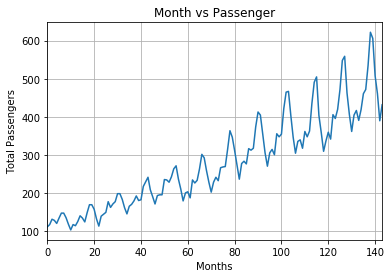

In [13]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

## Data processing

In [14]:
all_data = flight_data['passengers'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


We split the dataset in training/validation datasets and then apply normalization.

In [15]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [16]:
def create_inout_sequences(input_data, tw): #sliding window
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_window = 24
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear1 = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)

        predictions = self.linear1(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

## Training :

In [18]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 200
list_loss = []
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        list_loss.append(single_loss.item())

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00002837
epoch:  26 loss: 0.07157641
epoch:  51 loss: 0.02582951
epoch:  76 loss: 0.00075811
epoch: 101 loss: 0.02146182
epoch: 126 loss: 0.00000754
epoch: 151 loss: 0.00314191
epoch: 176 loss: 0.00305930
epoch: 201 loss: 0.00092407
epoch: 226 loss: 0.00000677
epoch: 251 loss: 0.00056248
epoch: 276 loss: 0.00053775
epoch: 301 loss: 0.00892411
epoch: 326 loss: 0.00004101
epoch: 351 loss: 0.00015309
epoch: 376 loss: 0.00132317
epoch: 401 loss: 0.00000428
epoch: 426 loss: 0.00007538
epoch: 451 loss: 0.00370804
epoch: 476 loss: 0.00421513
epoch: 501 loss: 0.00006547
epoch: 526 loss: 0.00439694
epoch: 551 loss: 0.00009476
epoch: 576 loss: 0.00402024
epoch: 601 loss: 0.00487847
epoch: 626 loss: 0.00099444
epoch: 651 loss: 0.01219956
epoch: 676 loss: 0.11488440
epoch: 701 loss: 0.00035986
epoch: 726 loss: 0.00110358
epoch: 751 loss: 0.00013335
epoch: 776 loss: 0.00082238
epoch: 801 loss: 0.00021066
epoch: 826 loss: 0.01269833
epoch: 851 loss: 0.00014143
epoch: 876 loss: 0.0

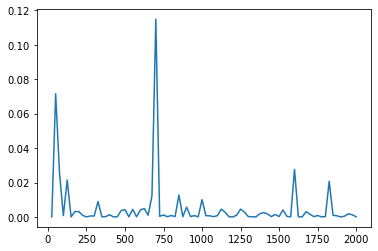

In [19]:
plt.plot(range(25,epochs+1,25),list_loss)

## Sampling : 

In [20]:
fut_pred = 12

test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [21]:
model.eval()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())


test_inputs[fut_pred:]
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[400.52441077]
 [390.69968188]
 [390.72729015]
 [383.81586147]
 [374.303519  ]
 [370.98142037]
 [365.55021086]
 [355.62694104]
 [343.7282964 ]
 [330.20102793]
 [315.36518009]
 [300.23417728]]


## Visualization : 

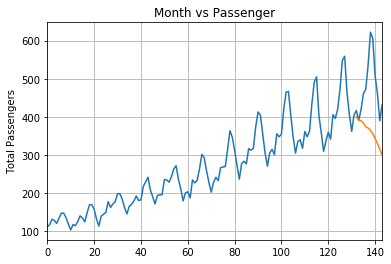

In [22]:
x = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

## Other Dataset : 